# 🔍 SERP Hard/Soft Clustering Engine v2.2

### Что нового в v2.2 (оптимизация для degeneracy 935+)

Проблема v2.1: даже greedy fallback медленный на компоненте 114K вершин,
потому что на каждой итерации сканирует все вершины `O(N)`.

Решения v2.2:
1. **Pre-computed adjacency sets** — конвертируем igraph в `Dict[int, Set[int]]` один раз,
   дальше только set-операции (в 100× быстрее повторных `subG.neighbors()`)
2. **Candidate pruning** — при добавлении вершины в клику сужаем кандидатов через `&=`,
   клика строится за `O(D)` вместо `O(D²)`
3. **Pre-sorted seeds** — вершины отсортированы по degree один раз, не ищем max каждый раз
4. **K-core stratification** — обрабатываем слои по coreness:
   плотное ядро (935-core) отдельно от разреженной оболочки

## ⚙️ 1. Конфигурация

In [1]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  НАСТРОЙКИ                                                   ║
# ╚══════════════════════════════════════════════════════════════╝

INPUT_FILE        = "serp_data.csv"
CSV_SEPARATOR     = ";"
COL_KEYWORD       = "keyword"
COL_URL           = "url"

MIN_COMMON_URLS   = 3
MAX_URLS_PER_KW   = 10
MIN_CLIQUE_SIZE   = 2

NUM_WORKERS        = 0          # 0 = auto
SMALL_COMP_THRESH  = 150
DEGENERACY_LIMIT   = 50         # igraph точный ≤ этого, greedy >

EDGE_METHOD       = "inverted_index"  # "sparse_matrix" для 100K+
SPARSE_TOP_N      = 200
SPARSE_THREADS    = 8

OUTPUT_FILE       = "clusters_output.csv" 

## 📦 2. Импорты

In [2]:
import csv
import gc
import logging
import os
import time
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count
from typing import Dict, List, Set, Tuple

import numpy as np
import pandas as pd
import psutil
import igraph as ig
from tqdm.notebook import tqdm
tqdm.pandas()

from urllib.parse import urlparse

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s",
                    datefmt="%H:%M:%S")

if NUM_WORKERS == 0:
    NUM_WORKERS = max(1, cpu_count() - 2)

print(f"CPU: {cpu_count()} cores, Workers: {NUM_WORKERS}")
print(f"RAM: {psutil.virtual_memory().total/(1024**3):.0f} GB total, "
      f"{psutil.virtual_memory().available/(1024**3):.0f} GB free")

CPU: 32 cores, Workers: 30
RAM: 246 GB total, 226 GB free


## 🔤 2.1. Обработка SERP

In [3]:
serp = pd.read_parquet('serp.parquet')
serp = serp[['original_search_query','url']]
serp = serp.rename(columns={'original_search_query': 'keyword'})
serp = serp.sort_values(by=['keyword'], ascending=[True])

serp.head()

,keyword,url
2145449,0 2 мм сколько микрон,https://www.unitconverters.net/length/millimet...
2125885,0 2 мм сколько микрон,https://www.calculateme.com/length/millimeters...
2130956,0 2 мм сколько микрон,https://www.inchcalculator.com/convert/millime...
2189892,0 2 мм сколько микрон,https://oxiss.ru/articles/tolshchina-polietile...
2175078,0 2 мм сколько микрон,https://www.translatorscafe.com/unit-converter...


In [4]:
serp.to_csv('serp_data.csv', sep = ';', index = False)

In [5]:
serp = pd.read_csv('cluster-testing.csv', on_bad_lines = 'skip', sep = ';')
serp = serp.rename(columns={'Phrase':'keyword','URL':'url'})
serp['keyword'] = serp['keyword'].ffill()
serp = serp.sort_values(by=['keyword'], ascending=[True])
serp.head()

,keyword,url,Position
32992,1 млн в кредит,https://www.sravni.ru/kredity/na-1000000-ruble...,3
32999,1 млн в кредит,https://www.vtb.ru/personal/kredit/1000000-rub...,10
32998,1 млн в кредит,https://alfabank.ru/get-money/credit/1-mln-rub...,9
32997,1 млн в кредит,https://www.tbank.ru/loans/cash-loan/na-100000...,8
32996,1 млн в кредит,https://bankiros.ru/credits/na-1000000-rublej,7


In [6]:
serp[['keyword','url']].to_csv('serp_data.csv', sep = ';', index = False)

## 🔤 3. StringEncoder

In [20]:
class StringEncoder:
    __slots__ = ("_str2int", "_int2str", "_counter")
    def __init__(self):
        self._str2int = {}
        self._int2str = []
        self._counter = 0
    def encode(self, s):
        idx = self._str2int.get(s)
        if idx is not None: return idx
        idx = self._counter
        self._str2int[s] = idx
        self._int2str.append(s)
        self._counter += 1
        return idx
    def decode(self, idx): return self._int2str[idx]
    def __len__(self): return self._counter

## 📥 4. Загрузка данных

In [21]:
def load_serp_csv(input_file, separator, col_keyword, col_url, max_urls, chunk_size=500_000):
    kw_enc, url_enc = StringEncoder(), StringEncoder()
    kw2urls = defaultdict(set)
    total_rows = 0
    for chunk in pd.read_csv(input_file, sep=separator, usecols=[col_keyword, col_url],
                              dtype=str, chunksize=chunk_size, on_bad_lines="skip", engine="c"):
        chunk = chunk.dropna(subset=[col_keyword, col_url])
        chunk[col_keyword] = chunk[col_keyword].str.strip().str.lower()
        chunk[col_url] = chunk[col_url].str.strip()
        chunk = chunk[(chunk[col_keyword] != "") & (chunk[col_url] != "")]
        for kw_str, url_str in zip(chunk[col_keyword], chunk[col_url]):
            kw_id = kw_enc.encode(kw_str)
            url_id = url_enc.encode(url_str)
            if len(kw2urls[kw_id]) < max_urls:
                kw2urls[kw_id].add(url_id)
        total_rows += len(chunk)
    return dict(kw2urls), kw_enc, url_enc, total_rows

t = time.time()
kw2urls, kw_enc, url_enc, total_rows = load_serp_csv(
    INPUT_FILE, CSV_SEPARATOR, COL_KEYWORD, COL_URL, MAX_URLS_PER_KW)
all_kw_ids = set(kw2urls.keys())
print(f"Строк: {total_rows:,}, Запросов: {len(kw_enc):,}, URL: {len(url_enc):,} [{time.time()-t:.1f}s]")

Строк: 165,313, Запросов: 16,521, URL: 16,582 [0.9s]


## 🔗 5. Inverted Index + Рёбра

In [22]:
def build_inverted_index(kw2urls):
    url2kws = defaultdict(list)
    for kw_id, url_ids in kw2urls.items():
        for url_id in url_ids:
            url2kws[url_id].append(kw_id)
    return dict(url2kws)

def build_edges_inverted(kw2urls, url2kws, min_common):
    pair_counts = defaultdict(int)
    for url_id, kw_list in tqdm(sorted(url2kws.items(), key=lambda x: len(x[1])),
                                 desc="Edge counting"):
        n = len(kw_list)
        if n < 2: continue
        kw_sorted = sorted(kw_list)
        for i in range(n):
            for j in range(i+1, n):
                pair_counts[(kw_sorted[i], kw_sorted[j])] += 1
    edges = [(a, b) for (a, b), cnt in pair_counts.items() if cnt >= min_common]
    print(f"Пар: {len(pair_counts):,}, Рёбер ≥{min_common}: {len(edges):,}")
    del pair_counts; gc.collect()
    return edges

def build_edges_sparse(kw2urls, min_common=3, num_threads=8, top_n=200):
    from scipy.sparse import csr_matrix
    try:
        from sparse_dot_topn import sp_matmul_topn; has_sdtn = True
    except ImportError: has_sdtn = False

    kw_ids = sorted(kw2urls.keys()); n_kw = len(kw_ids)
    max_url = max(max(s) for s in kw2urls.values() if s)
    kw2row = {kw: i for i, kw in enumerate(kw_ids)}
    row2kw = {i: kw for i, kw in enumerate(kw_ids)}
    rows, cols, data = [], [], []
    for kw_id in kw_ids:
        for url_id in kw2urls[kw_id]:
            rows.append(kw2row[kw_id]); cols.append(url_id); data.append(1.0)
    A = csr_matrix((data, (rows, cols)), shape=(n_kw, max_url+1), dtype=np.float32)
    del rows, cols, data; gc.collect()
    if has_sdtn:
        overlap = sp_matmul_topn(A, A.T, top_n=top_n, threshold=float(min_common),
                                  n_threads=num_threads, sort=False)
    else:
        overlap = A.dot(A.T).tocsr()
        overlap.data[overlap.data < min_common] = 0; overlap.eliminate_zeros()
    coo = overlap.tocoo()
    edges = [(row2kw[i], row2kw[j]) for i,j,v in zip(coo.row, coo.col, coo.data) if i<j and v>=min_common]
    del overlap, coo, A; gc.collect()
    return edges

t = time.time()
url2kws = build_inverted_index(kw2urls)
print(f"Inverted index: {len(url2kws):,} URLs")
if EDGE_METHOD == "sparse_matrix":
    edges = build_edges_sparse(kw2urls, MIN_COMMON_URLS, SPARSE_THREADS, SPARSE_TOP_N)
else:
    edges = build_edges_inverted(kw2urls, url2kws, MIN_COMMON_URLS)
del url2kws; gc.collect()
print(f"Рёбер: {len(edges):,} [{time.time()-t:.1f}s]")

Inverted index: 16,581 URLs


Edge counting:   0%|          | 0/16581 [00:00<?, ?it/s]

Пар: 1,902,926, Рёбер ≥3: 1,176,972
Рёбер: 1,176,972 [5.0s]


## 📊 6. Граф + компоненты

In [23]:
def build_igraph(edges, all_kw_ids):
    node_set = set()
    for a, b in edges: node_set.add(a); node_set.add(b)
    node_set.update(all_kw_ids)
    nodes = sorted(node_set)
    kw2v = {kw: i for i, kw in enumerate(nodes)}
    v2kw = {i: kw for i, kw in enumerate(nodes)}
    G = ig.Graph(n=len(nodes), edges=[(kw2v[a], kw2v[b]) for a, b in edges], directed=False)
    G.simplify()
    return G, kw2v, v2kw

def get_components(G):
    m = G.connected_components(mode="weak").membership
    c2v = defaultdict(list)
    for v, c in enumerate(m): c2v[c].append(v)
    return sorted(c2v.values(), key=len, reverse=True)

t = time.time()
G, kw2vertex, vertex2kw = build_igraph(edges, all_kw_ids)
del edges; gc.collect()
components = get_components(G)
sizes = [len(c) for c in components]
print(f"Граф: {G.vcount():,} вершин, {G.ecount():,} рёбер")
print(f"Компонент: {len(components):,}, макс: {max(sizes):,}")
for label, lo, hi in [("1",1,1),("2-10",2,10),("11-100",11,100),
                       ("101-1K",101,1000),("1K-10K",1001,10000),("10K+",10001,999999999)]:
    cnt = sum(1 for s in sizes if lo <= s <= hi)
    if cnt: print(f"  {label:>8}: {cnt:,}")
print(f"[{time.time()-t:.1f}s]")

Граф: 16,521 вершин, 1,176,972 рёбер
Компонент: 369, макс: 6,380
         1: 130
      2-10: 138
    11-100: 88
    101-1K: 11
    1K-10K: 2
[1.3s]


## 🔬 7. Диагностика компонент

Degeneracy определяет сложность `O(d·n·3^(d/3))`.
Ваша компонента #1: degeneracy=935, `3^(935/3)` = число с 149 знаками. Полный перебор невозможен.

In [24]:
def diagnose_components(G, components, top_n=15):
    print(f"{'#':>3} {'Вершин':>8} {'Рёбер':>10} {'Плотн.':>7} "
          f"{'Degen.':>7} {'MaxDeg':>7} {'Прогноз'}")
    print("-" * 65)
    results = []
    for i, comp in enumerate(components[:top_n]):
        if len(comp) < 2: continue
        subG = G.subgraph(comp)
        n, m = subG.vcount(), subG.ecount()
        density = m / (n*(n-1)/2) if n > 1 else 0
        max_deg = max(subG.degree())
        degen = max(subG.coreness())
        if degen <= 30: fc = "✅"
        elif degen <= DEGENERACY_LIMIT: fc = "⚠️ igraph"
        else: fc = f"🔥 greedy"
        print(f"{i+1:>3} {n:>8,} {m:>10,} {density:>7.3f} {degen:>7} {max_deg:>7,} {fc}")
        results.append((i, len(comp), degen))
    return results

diag = diagnose_components(G, components)

  #   Вершин      Рёбер  Плотн.  Degen.  MaxDeg Прогноз
-----------------------------------------------------------------
  1    6,380    842,151   0.041     839   1,095 🔥 greedy
  2    4,391    201,818   0.021     203     401 🔥 greedy
  3      499      9,902   0.080      34     102 ⚠️ igraph
  4      401     10,004   0.125      64     110 🔥 greedy
  5      354     10,033   0.161      79     107 🔥 greedy
  6      299     31,039   0.697     180     272 🔥 greedy
  7      183     16,222   0.974     172     181 🔥 greedy
  8      143      5,209   0.513      85     114 🔥 greedy
  9      142      4,744   0.474      73     106 🔥 greedy
 10      129      1,385   0.168      19      43 ✅
 11      126      2,072   0.263      55      59 🔥 greedy
 12      121      3,696   0.509      61      98 🔥 greedy
 13      115      2,196   0.335      47      83 ⚠️ igraph
 14       88      1,899   0.496      46      69 ⚠️ igraph
 15       67      1,962   0.887      58      63 🔥 greedy


## 💎 8. Поиск клик v2.2

### Ключевая оптимизация: `fast_greedy_cliques`

Старый greedy (v2.1):
```
на каждой итерации:
    scan ALL vertices for max degree  → O(N)
    for each candidate: check neighbors → O(D)
итого: O(N² × D)  при N=114K → ЧАСЫ
```

Новый fast greedy (v2.2):
```
pre-sort vertices by degree ONCE     → O(N log N)
pre-compute adj as Dict[Set] ONCE    → O(N + M)
for each seed:
    candidates = adj[seed] - assigned → O(D)  set operation
    for v in candidates:
        if clique ⊂ adj[v]: add      → O(clique_size)
        candidates &= adj[v]          → PRUNING! O(D) → O(d)
итого: O(N × D)  при N=114K → СЕКУНДЫ
```

Ключ: `candidates &= adj[v]` — при каждом добавлении вершины в клику
множество кандидатов сужается. К 3-4 вершине в клике кандидатов остаётся единицы.

In [25]:
def igraph_to_adj_sets(G, vertices=None):
    """Конвертируем igraph в Dict[int, Set[int]] — один раз.
    Все дальнейшие операции через set, без вызовов igraph."""
    adj = {}
    if vertices is None:
        for v in range(G.vcount()):
            adj[v] = set(G.neighbors(v))
    else:
        vset = set(vertices)
        for v in vertices:
            adj[v] = set(G.neighbors(v)) & vset
    return adj


def fast_greedy_cliques(adj, min_clique_size=2, verbose=True):
    """
    Быстрая жадная экстракция клик.

    Оптимизации vs v2.1:
    1. Вершины отсортированы по degree ОДИН РАЗ (не ищем max на каждой итерации)
    2. adj — готовые set, никаких вызовов igraph
    3. Candidate pruning: candidates &= adj[v] при каждом добавлении
    4. Skip assigned через set lookup O(1)
    """
    assigned = set()
    cliques = []

    # Сортируем по degree descending — один раз
    seeds = sorted(adj.keys(), key=lambda v: len(adj[v]), reverse=True)

    t0 = time.time()
    for idx, seed in enumerate(seeds):
        if seed in assigned:
            continue

        # Кандидаты = соседи seed, ещё не назначенные
        candidates = adj[seed] - assigned
        if len(candidates) < min_clique_size - 1:
            continue

        # Строим клику жадно с pruning
        clique = {seed}

        # Сортируем кандидатов по связям с другими кандидатами (эвристика)
        sorted_cands = sorted(candidates,
                              key=lambda v: len(adj[v] & candidates),
                              reverse=True)

        # Рабочее множество кандидатов — будет сужаться
        remaining = set(sorted_cands)

        for v in sorted_cands:
            if v not in remaining:
                continue
            # v связан со ВСЕМИ текущими членами клики?
            if clique.issubset(adj[v]):
                clique.add(v)
                # PRUNING: оставляем только соседей v
                remaining &= adj[v]

        if len(clique) >= min_clique_size:
            cliques.append(frozenset(clique))
            assigned.update(clique)

        # Прогресс
        if verbose and (idx + 1) % 5000 == 0:
            elapsed = time.time() - t0
            pct = len(assigned) / len(adj) * 100
            print(f"    {idx+1:,}/{len(seeds):,} seeds, "
                  f"{len(cliques):,} клик, "
                  f"{len(assigned):,} назначено ({pct:.0f}%), "
                  f"{elapsed:.1f}s")

    if verbose:
        elapsed = time.time() - t0
        print(f"    fast_greedy done: {len(cliques):,} клик, "
              f"{len(assigned):,}/{len(adj):,} назначено, {elapsed:.1f}s")

    return [set(c) for c in cliques]


def process_component(G, comp, min_clique_size, degeneracy_limit, comp_idx=0):
    """Обработка одной компоненты: igraph или fast_greedy."""

    n = len(comp)
    if n < min_clique_size:
        return []

    subG = G.subgraph(comp)
    coreness = subG.coreness()
    max_core = max(coreness) if coreness else 0

    # Маппинг local → global
    l2g = {i: comp[i] for i in range(n)}

    if max_core <= degeneracy_limit:
        # igraph точно
        result = []
        for c in subG.maximal_cliques(min=min_clique_size):
            result.append({l2g[v] for v in c})
        return result

    # K-core split
    shell_local = [v for v in range(n) if coreness[v] <= degeneracy_limit]
    core_local = [v for v in range(n) if coreness[v] > degeneracy_limit]

    print(f"  Comp #{comp_idx+1} ({n:,} вершин): "
          f"degen={max_core}, shell={len(shell_local):,}, core={len(core_local):,}")

    result = []

    # Shell → igraph (если degeneracy оболочки позволяет)
    if len(shell_local) >= min_clique_size:
        shell_sub = subG.subgraph(shell_local)
        shell_degen = max(shell_sub.coreness()) if shell_sub.vcount() > 0 else 0
        sm = {i: shell_local[i] for i in range(len(shell_local))}
        if shell_degen <= degeneracy_limit:
            for c in shell_sub.maximal_cliques(min=min_clique_size):
                result.append({l2g[sm[v]] for v in c})
            print(f"    shell: {len(result):,} клик (igraph, degen={shell_degen})")
        else:
            # Shell тоже плотная — greedy
            shell_global = [comp[v] for v in shell_local]
            adj = igraph_to_adj_sets(G, shell_global)
            shell_cliques = fast_greedy_cliques(adj, min_clique_size, verbose=False)
            result.extend(shell_cliques)
            print(f"    shell: {len(shell_cliques):,} клик (greedy, degen={shell_degen})")

    # Core → fast greedy (всегда, т.к. degeneracy > limit)
    if len(core_local) >= min_clique_size:
        core_global = [comp[v] for v in core_local]
        adj = igraph_to_adj_sets(G, core_global)
        core_cliques = fast_greedy_cliques(adj, min_clique_size)
        result.extend(core_cliques)
        print(f"    core:  {len(core_cliques):,} клик (fast_greedy)")

    return result

print("✅ Fast greedy engine ready")

✅ Fast greedy engine ready


### Worker для мультипроцессинга

In [26]:
def _worker_v22(args):
    """Worker: создаёт локальный igraph и обрабатывает компоненту."""
    import igraph as ig
    edge_list, node_list, min_clique_size, degeneracy_limit = args

    local_nodes = sorted(set(node_list))
    n2l = {n: i for i, n in enumerate(local_nodes)}
    l2n = {i: n for i, n in enumerate(local_nodes)}

    local_edges = [(n2l[a], n2l[b]) for a, b in edge_list if a in n2l and b in n2l]
    subG = ig.Graph(n=len(local_nodes), edges=local_edges, directed=False)
    subG.simplify()

    coreness = subG.coreness()
    max_core = max(coreness) if coreness else 0
    n = subG.vcount()
    result = []

    if max_core <= degeneracy_limit:
        for c in subG.maximal_cliques(min=min_clique_size):
            result.append(sorted(l2n[v] for v in c))
        return result

    # K-core split
    shell = [v for v in range(n) if coreness[v] <= degeneracy_limit]
    core = [v for v in range(n) if coreness[v] > degeneracy_limit]

    # Shell → igraph
    if len(shell) >= min_clique_size:
        ss = subG.subgraph(shell)
        sd = max(ss.coreness()) if ss.vcount() > 0 else 0
        sm = {i: shell[i] for i in range(len(shell))}
        if sd <= degeneracy_limit:
            for c in ss.maximal_cliques(min=min_clique_size):
                result.append(sorted(l2n[sm[v]] for v in c))
        else:
            # shell тоже плотная
            shell_ids = [local_nodes[v] for v in shell]
            shell_set = set(shell)
            adj = {}
            for v in shell:
                adj[local_nodes[v]] = {local_nodes[u] for u in subG.neighbors(v) if u in shell_set}
            for clique in _fast_greedy_worker(adj, min_clique_size):
                result.append(sorted(clique))

    # Core → fast greedy
    if len(core) >= min_clique_size:
        core_set = set(core)
        adj = {}
        for v in core:
            adj[local_nodes[v]] = {local_nodes[u] for u in subG.neighbors(v) if u in core_set}
        for clique in _fast_greedy_worker(adj, min_clique_size):
            result.append(sorted(clique))

    return result


def _fast_greedy_worker(adj, min_clique_size):
    """Greedy без print (для worker)."""
    assigned = set()
    cliques = []
    seeds = sorted(adj.keys(), key=lambda v: len(adj[v]), reverse=True)

    for seed in seeds:
        if seed in assigned: continue
        candidates = adj[seed] - assigned
        if len(candidates) < min_clique_size - 1: continue

        clique = {seed}
        sorted_c = sorted(candidates, key=lambda v: len(adj[v] & candidates), reverse=True)
        remaining = set(sorted_c)

        for v in sorted_c:
            if v not in remaining: continue
            if clique.issubset(adj[v]):
                clique.add(v)
                remaining &= adj[v]

        if len(clique) >= min_clique_size:
            cliques.append(frozenset(clique))
            assigned.update(clique)

    return [set(c) for c in cliques]

print("✅ Worker ready")

✅ Worker ready


### 🚀 Запуск поиска клик (Soft)

In [27]:
#new
t = time.time()
raw_cliques = []; large_tasks = []
for comp in components:
    if len(comp) < MIN_CLIQUE_SIZE: continue
    if len(comp) <= SMALL_COMP_THRESH:
        subG = G.subgraph(comp)
        degen = max(subG.coreness()) if subG.vcount()>0 else 0
        l2g = {i: comp[i] for i in range(len(comp))}
        if degen <= DEGENERACY_LIMIT:
            for c in subG.maximal_cliques(min=MIN_CLIQUE_SIZE):
                raw_cliques.append({l2g[v] for v in c})
        else:
            adj = igraph_to_adj_sets(G, comp)
            raw_cliques.extend(fast_greedy_cliques(adj, MIN_CLIQUE_SIZE, verbose=False))
    else:
        large_tasks.append(comp)
print(f"Малые компоненты: {len(raw_cliques):,} клик")
print(f"Больших: {len(large_tasks)}")
for i, comp in enumerate(large_tasks):
    print(f"\nКомпонента {i+1}/{len(large_tasks)}: {len(comp):,} вершин")
    t_c = time.time()
    cc = process_component(G, comp, MIN_CLIQUE_SIZE, DEGENERACY_LIMIT, i)
    raw_cliques.extend(cc)
    print(f"  → {len(cc):,} клик за {time.time()-t_c:.1f}s, всего: {len(raw_cliques):,}")

raw_cliques_kw = [{vertex2kw[v] for v in c} for c in raw_cliques]
del raw_cliques; gc.collect()
print(f"\nСырых клик (попарное условие): {len(raw_cliques_kw):,} [{time.time()-t:.1f}s]")

Малые компоненты: 1,939 клик
Больших: 7

Компонента 1/7: 6,380 вершин
  Comp #1 (6,380 вершин): degen=839, shell=1,864, core=4,516
    shell: 3,058 клик (igraph, degen=50)
    fast_greedy done: 200 клик, 4,460/4,516 назначено, 0.2s
    core:  200 клик (fast_greedy)
  → 3,258 клик за 0.7s, всего: 5,197

Компонента 2/7: 4,391 вершин
  Comp #2 (4,391 вершин): degen=203, shell=2,117, core=2,274
    shell: 18,206 клик (igraph, degen=44)
    fast_greedy done: 138 клик, 2,247/2,274 назначено, 0.0s
    core:  138 клик (fast_greedy)
  → 18,344 клик за 0.3s, всего: 23,541

Компонента 3/7: 499 вершин
  → 2,991 клик за 0.0s, всего: 26,532

Компонента 4/7: 401 вершин
  Comp #4 (401 вершин): degen=64, shell=300, core=101
    shell: 184 клик (igraph, degen=47)
    fast_greedy done: 4 клик, 100/101 назначено, 0.0s
    core:  4 клик (fast_greedy)
  → 188 клик за 0.0s, всего: 26,720

Компонента 5/7: 354 вершин
  Comp #5 (354 вершин): degen=79, shell=256, core=98
    shell: 1,906 клик (igraph, degen=43)


### 🎯 Глобальная проверка + сужение клик (Hard)

Для каждой найденной клики:
1. Считаем `∩ URL` всех запросов
2. `≥ N` → оставляем ✅
3. `< N` → убираем самый «слабый» запрос и повторяем
4. Если осталось `< MIN_CLIQUE_SIZE` → отбрасываем

**«Слабый» запрос** = тот, чьё удаление максимально увеличивает глобальное пересечение.

In [15]:
#v4 - итеративный жадный поиск максимальной клики


def enforce_global_condition_igraph_iterative(raw_cliques_kw, kw2urls, 
                                              min_common=3, min_clique_size=2):
    start_time = time.time()
    passed = 0
    shrunk = 0
    dropped = 0
    result = []

    for clique in tqdm(raw_cliques_kw, desc="Глобальная проверка"):
        members = set(clique)
        if len(members) < min_clique_size:
            dropped += 1
            continue

        remaining = members.copy()

        # --- итеративно строим максимальные клики ---
        while len(remaining) >= min_clique_size:
            # строим рёбра для оставшихся keywords
            edges = [(k1, k2) 
                     for i, k1 in enumerate(remaining) 
                     for j, k2 in enumerate(list(remaining)[i+1:], i+1)
                     if len(kw2urls.get(k1, set()) & kw2urls.get(k2, set())) >= min_common]

            if not edges:
                # нельзя построить клику из оставшихся
                for kw in remaining:
                    result.append((set([kw]), frozenset(kw2urls.get(kw, set()))))
                    dropped += 1
                break

            g = ig.Graph.TupleList(edges, directed=False)

            # --- жадный поиск максимальной клики ---
            visited = set()
            max_clique = set()
            for v_name in remaining:
                if v_name in visited:
                    continue
                if v_name not in g.vs['name']:
                    continue
                clique_set = {v_name}
                idx = g.vs.find(name=v_name).index
                neighbors = {g.vs[n]['name'] for n in g.neighbors(idx)}
                candidate_neighbors = neighbors - clique_set

                while candidate_neighbors:
                    best_add = None
                    best_common_size = -1
                    for n in candidate_neighbors:
                        trial_clique = clique_set | {n}
                        url_sets_trial = [kw2urls.get(k,set()) for k in trial_clique]
                        common_trial = set.intersection(*url_sets_trial) if url_sets_trial else set()
                        if len(common_trial) >= min_common and len(common_trial) > best_common_size:
                            best_common_size = len(common_trial)
                            best_add = n
                    if best_add is None:
                        break
                    clique_set.add(best_add)
                    candidate_neighbors.remove(best_add)
                    candidate_neighbors -= clique_set

                url_sets_final = [kw2urls.get(k,set()) for k in clique_set]
                common_final = set.intersection(*url_sets_final) if url_sets_final else set()

                if len(clique_set) >= min_clique_size and len(common_final) >= min_common:
                    for kw in clique_set:
                        if kw not in max_clique or len(clique_set) > len(max_clique):
                            max_clique = clique_set
                    visited.update(clique_set)

            # --- оценка результата ---
            if max_clique == remaining:
                passed += 1
            elif len(max_clique) >= min_clique_size:
                shrunk += 1
            else:
                # ничего не получилось собрать
                for kw in remaining:
                    result.append((set([kw]), frozenset(kw2urls.get(kw, set()))))
                    dropped += 1
                break

            url_sets_final = [kw2urls.get(k,set()) for k in max_clique]
            common_final = set.intersection(*url_sets_final) if url_sets_final else set()
            result.append((set(max_clique), frozenset(common_final)))

            # удаляем вершины, которые вошли в max_clique, для следующей итерации
            remaining -= max_clique

    # --- статистика ---
    print(f"\nБез изменений: {passed:,}, Сужены: {shrunk:,}, Отброшены: {dropped:,}")
    print(f"Итого клик: {len(result):,}")
    if result:
        sizes = [len(kw) for kw,_ in result]
        common_sizes = [len(u) for _,u in result]
        print(f"Размер: среднее {np.mean(sizes):.1f}, макс {max(sizes)}")
        print(f"Общих URL: среднее {np.mean(common_sizes):.1f}, мин {min(common_sizes)}, макс {max(common_sizes)}")
    print(f"[{time.time() - start_time:.1f}s]")

    return result


In [31]:
# фиксированный список
# v4 deterministic — итеративный жадный поиск максимальной клики
def enforce_global_condition_igraph_iterative(
        raw_cliques_kw, 
        kw2urls, 
        min_common=3, 
        min_clique_size=2):

    import igraph as ig
    import numpy as np
    import time
    from tqdm import tqdm

    start_time = time.time()
    passed = 0
    shrunk = 0
    dropped = 0
    result = []

    for clique in tqdm(raw_cliques_kw, desc="Глобальная проверка"):

        members = sorted(set(clique))  # фиксируем порядок

        if len(members) < min_clique_size:
            dropped += 1
            continue

        remaining = members[:]  # список, не set

        # --- итеративно строим максимальные клики ---
        while len(remaining) >= min_clique_size:

            nodes = remaining  # уже отсортированы

            # --- строим рёбра ---
            edges = []
            for i, k1 in enumerate(nodes):
                urls1 = kw2urls.get(k1, set())
                for k2 in nodes[i+1:]:
                    if len(urls1 & kw2urls.get(k2, set())) >= min_common:
                        edges.append((k1, k2))

            if not edges:
                # нельзя построить клику
                for kw in remaining:
                    result.append((set([kw]), frozenset(kw2urls.get(kw, set()))))
                    dropped += 1
                break

            g = ig.Graph.TupleList(edges, directed=False)

            visited = set()
            max_clique = set()

            # --- жадный поиск ---
            for v_name in nodes:  # фиксированный порядок

                if v_name in visited:
                    continue
                if v_name not in g.vs['name']:
                    continue

                clique_set = {v_name}

                idx = g.vs.find(name=v_name).index
                neighbors = sorted(g.vs[n]['name'] for n in g.neighbors(idx))
                candidate_neighbors = set(neighbors) - clique_set

                while candidate_neighbors:
                    best_add = None
                    best_common_size = -1

                    # фиксируем порядок проверки
                    for n in sorted(candidate_neighbors):
                        trial_clique = clique_set | {n}
                        url_sets_trial = [kw2urls.get(k, set()) for k in trial_clique]
                        common_trial = set.intersection(*url_sets_trial) if url_sets_trial else set()

                        if len(common_trial) >= min_common and len(common_trial) > best_common_size:
                            best_common_size = len(common_trial)
                            best_add = n

                    if best_add is None:
                        break

                    clique_set.add(best_add)
                    candidate_neighbors.remove(best_add)
                    candidate_neighbors -= clique_set

                # финальная проверка
                url_sets_final = [kw2urls.get(k, set()) for k in clique_set]
                common_final = set.intersection(*url_sets_final) if url_sets_final else set()

                if len(clique_set) >= min_clique_size and len(common_final) >= min_common:
                    if len(clique_set) > len(max_clique):
                        max_clique = clique_set.copy()
                    visited.update(clique_set)

            # --- оценка результата ---
            if set(max_clique) == set(remaining):
                passed += 1
            elif len(max_clique) >= min_clique_size:
                shrunk += 1
            else:
                for kw in remaining:
                    result.append((set([kw]), frozenset(kw2urls.get(kw, set()))))
                    dropped += 1
                break

            url_sets_final = [kw2urls.get(k, set()) for k in max_clique]
            common_final = set.intersection(*url_sets_final) if url_sets_final else set()
            result.append((set(max_clique), frozenset(common_final)))

            # удаляем использованные вершины (детерминированно)
            remaining = [x for x in remaining if x not in max_clique]

    # --- статистика ---
    print(f"\nБез изменений: {passed:,}, Сужены: {shrunk:,}, Отброшены: {dropped:,}")
    print(f"Итого клик: {len(result):,}")

    if result:
        sizes = [len(kw) for kw, _ in result]
        common_sizes = [len(u) for _, u in result]
        print(f"Размер: среднее {np.mean(sizes):.1f}, макс {max(sizes)}")
        print(f"Общих URL: среднее {np.mean(common_sizes):.1f}, мин {min(common_sizes)}, макс {max(common_sizes)}")

    print(f"[{time.time() - start_time:.1f}s]")

    return result


In [32]:
cliques_global = enforce_global_condition_igraph_iterative(
    raw_cliques_kw, 
    kw2urls, 
    min_common=MIN_COMMON_URLS, 
    min_clique_size=MIN_CLIQUE_SIZE
)

Глобальная проверка: 100%|██████████| 28652/28652 [03:45<00:00, 126.89it/s] 


Без изменений: 15,961, Сужены: 56,696, Отброшены: 0
Итого клик: 72,657
Размер: среднее 7.1, макс 588
Общих URL: среднее 3.3, мин 3, макс 10
[225.9s]


## Многопоток

#### Функция для обработки одной клики

In [33]:
def process_single_clique(clique, kw2urls, min_common=3, min_clique_size=2):
    import igraph as ig

    result = []
    passed = shrunk = dropped = 0

    members = sorted(set(clique))  # фиксируем порядок

    if len(members) < min_clique_size:
        dropped += 1
        return result, passed, shrunk, dropped

    remaining = members[:]  # список, НЕ set

    while len(remaining) >= min_clique_size:

        nodes = remaining  # уже отсортированы

        # --- строим рёбра детерминированно ---
        edges = []
        for i, k1 in enumerate(nodes):
            urls1 = kw2urls.get(k1, set())
            for k2 in nodes[i+1:]:
                if len(urls1 & kw2urls.get(k2, set())) >= min_common:
                    edges.append((k1, k2))

        if not edges:
            for kw in nodes:
                result.append((set([kw]), frozenset(kw2urls.get(kw, set()))))
                dropped += 1
            break

        g = ig.Graph.TupleList(edges, directed=False)

        visited = set()
        max_clique = set()

        for v_name in nodes:  # фиксированный порядок

            if v_name in visited:
                continue
            if v_name not in g.vs['name']:
                continue

            clique_set = {v_name}

            idx = g.vs.find(name=v_name).index
            neighbors = sorted(g.vs[n]['name'] for n in g.neighbors(idx))
            candidate_neighbors = set(neighbors) - clique_set

            while candidate_neighbors:
                best_add = None
                best_common_size = -1

                for n in sorted(candidate_neighbors):  # фиксируем порядок
                    trial_clique = clique_set | {n}
                    url_sets_trial = [kw2urls.get(k, set()) for k in trial_clique]
                    common_trial = set.intersection(*url_sets_trial) if url_sets_trial else set()

                    if len(common_trial) >= min_common and len(common_trial) > best_common_size:
                        best_common_size = len(common_trial)
                        best_add = n

                if best_add is None:
                    break

                clique_set.add(best_add)
                candidate_neighbors.remove(best_add)

            url_sets_final = [kw2urls.get(k, set()) for k in clique_set]
            common_final = set.intersection(*url_sets_final) if url_sets_final else set()

            if len(clique_set) >= min_clique_size and len(common_final) >= min_common:
                if len(clique_set) > len(max_clique):
                    max_clique = clique_set.copy()
                visited.update(clique_set)

        if set(max_clique) == set(nodes):
            passed += 1
        elif len(max_clique) >= min_clique_size:
            shrunk += 1
        else:
            for kw in nodes:
                result.append((set([kw]), frozenset(kw2urls.get(kw, set()))))
                dropped += 1
            break

        url_sets_final = [kw2urls.get(k, set()) for k in max_clique]
        common_final = set.intersection(*url_sets_final) if url_sets_final else set()
        result.append((set(max_clique), frozenset(common_final)))

        # удаляем детерминированно
        remaining = [x for x in nodes if x not in max_clique]

    return result, passed, shrunk, dropped


#### Worker для Hard кластеризации

In [34]:
def enforce_global_condition_igraph_iterative_mp(
        raw_cliques_kw, kw2urls,
        min_common=3,
        min_clique_size=2,
        max_workers=8):

    import time
    import numpy as np
    from concurrent.futures import ProcessPoolExecutor
    from tqdm import tqdm

    start_time = time.time()

    total_passed = total_shrunk = total_dropped = 0
    results = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:

        iterator = executor.map(
            process_single_clique,
            raw_cliques_kw,
            [kw2urls] * len(raw_cliques_kw),
            [min_common] * len(raw_cliques_kw),
            [min_clique_size] * len(raw_cliques_kw)
        )

        for res, passed, shrunk, dropped in tqdm(iterator, total=len(raw_cliques_kw),
                                                 desc="Глобальная проверка (MP)"):
            results.extend(res)
            total_passed += passed
            total_shrunk += shrunk
            total_dropped += dropped

    print(f"\nБез изменений: {total_passed:,}, Сужены: {total_shrunk:,}, Отброшены: {total_dropped:,}")
    print(f"Итого клик: {len(results):,}")

    if results:
        sizes = [len(kw) for kw, _ in results]
        common_sizes = [len(u) for _, u in results]
        print(f"Размер: среднее {np.mean(sizes):.1f}, макс {max(sizes)}")
        print(f"Общих URL: среднее {np.mean(common_sizes):.1f}, мин {min(common_sizes)}, макс {max(common_sizes)}")

    print(f"[{time.time() - start_time:.1f}s]")

    return results


In [35]:
cliques_global = enforce_global_condition_igraph_iterative_mp(
    raw_cliques_kw, 
    kw2urls, 
    min_common=MIN_COMMON_URLS, 
    min_clique_size=MIN_CLIQUE_SIZE,
    max_workers=NUM_WORKERS  # число процессов, можно подбирать по CPU
)


Глобальная проверка (MP): 100%|██████████| 28652/28652 [08:27<00:00, 56.47it/s]  



Без изменений: 15,961, Сужены: 56,696, Отброшены: 0
Итого клик: 72,657
Размер: среднее 7.1, макс 588
Общих URL: среднее 3.3, мин 3, макс 10
[514.1s]


In [37]:
import numpy as np
import igraph as ig
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import time

# =========================
# 1️⃣ Преобразуем URL в numpy masks
# =========================
def build_kw2mask(kw2urls):
    """
    kw2urls: dict, key -> set(url)
    Возвращает:
        kw2mask: dict, key -> numpy bool array
        url2id: dict, url -> int
    """
    all_urls = sorted({u for urls in kw2urls.values() for u in urls})
    url2id = {u: i for i, u in enumerate(all_urls)}
    N_urls = len(all_urls)

    kw2mask = {}
    for kw, urls in kw2urls.items():
        mask = np.zeros(N_urls, dtype=bool)
        for u in urls:
            mask[url2id[u]] = True
        kw2mask[kw] = mask
    return kw2mask, url2id

# =========================
# 2️⃣ Построение графа и edge_common_masks
# =========================
def build_adjacency_numpy(kw2mask, min_common=3):
    """
    Возвращает edges и edge_common_masks
    edge_common_masks[(k1,k2)] = numpy bool array с общими URL
    """
    from itertools import combinations
    edges = []
    edge_common_masks = {}

    kws = list(kw2mask.keys())
    for i, k1 in enumerate(kws):
        for k2 in kws[i+1:]:
            common_mask = kw2mask[k1] & kw2mask[k2]
            if np.sum(common_mask) >= min_common:
                edges.append((k1, k2))
                edge_common_masks[(k1,k2)] = common_mask
                edge_common_masks[(k2,k1)] = common_mask
    # добавляем диагональные маски для отдельных keywords
    for k in kws:
        edge_common_masks[(k,k)] = kw2mask[k]
    return edges, edge_common_masks

# =========================
# 3️⃣ Глобальные переменные для процессов
# =========================
GLOBAL_G = None
GLOBAL_EDGE_COMMON_MASKS = None
GLOBAL_MIN_COMMON = None
GLOBAL_MIN_CLIQUE = None

def init_worker(G, edge_common_masks, min_common, min_clique_size):
    global GLOBAL_G, GLOBAL_EDGE_COMMON_MASKS, GLOBAL_MIN_COMMON, GLOBAL_MIN_CLIQUE
    GLOBAL_G = G
    GLOBAL_EDGE_COMMON_MASKS = edge_common_masks
    GLOBAL_MIN_COMMON = min_common
    GLOBAL_MIN_CLIQUE = min_clique_size

# =========================
# 4️⃣ Worker для одной клики
# =========================
def process_clique_worker(clique):
    result = []
    members = set(clique)
    remaining = list(members)
    visited = set()

    while len(remaining) >= GLOBAL_MIN_CLIQUE:
        best_local_clique = set()

        for v_name in sorted(remaining):
            if v_name in visited:
                continue
            clique_set = {v_name}
            idx = GLOBAL_G.vs.find(name=v_name).index
            neighbors = [GLOBAL_G.vs[n]['name'] for n in GLOBAL_G.neighbors(idx)]
            candidate_neighbors = set(neighbors) - clique_set

            while candidate_neighbors:
                best_add = None
                best_common_size = -1
                for n in sorted(candidate_neighbors):
                    # пересечение через numpy mask
                    common_mask = None
                    for c in clique_set:
                        if common_mask is None:
                            common_mask = GLOBAL_EDGE_COMMON_MASKS[(c,n)].copy()
                        else:
                            common_mask &= GLOBAL_EDGE_COMMON_MASKS[(c,n)]
                        if np.sum(common_mask) < GLOBAL_MIN_COMMON:
                            break
                    if common_mask is not None and np.sum(common_mask) >= GLOBAL_MIN_COMMON:
                        if np.sum(common_mask) > best_common_size:
                            best_common_size = np.sum(common_mask)
                            best_add = n
                if best_add is None:
                    break
                clique_set.add(best_add)
                candidate_neighbors.remove(best_add)

            if len(clique_set) > len(best_local_clique):
                best_local_clique = clique_set

        if not best_local_clique:
            # не смогли собрать клику
            for kw in remaining:
                mask = GLOBAL_EDGE_COMMON_MASKS[(kw,kw)]
                result.append((set([kw]), frozenset(np.where(mask)[0])))
            break

        # финальные общие URL
        common_mask = None
        for c in best_local_clique:
            if common_mask is None:
                common_mask = GLOBAL_EDGE_COMMON_MASKS[(c,c)].copy()
            else:
                for other in best_local_clique:
                    if other != c:
                        common_mask &= GLOBAL_EDGE_COMMON_MASKS[(c,other)]
        result.append((set(best_local_clique), frozenset(np.where(common_mask)[0])))
        visited.update(best_local_clique)
        remaining = [x for x in remaining if x not in best_local_clique]

    return result

# =========================
# 5️⃣ Многопроцессорный pipeline
# =========================
def enforce_global_condition_igraph_iterative_mp(raw_cliques_kw, kw2urls,
                                                 min_common=3, min_clique_size=2,
                                                 max_workers=8):
    start_time = time.time()

    # 1️⃣ kw2mask
    print("Преобразуем URL в numpy masks...")
    kw2mask, url2id = build_kw2mask(kw2urls)

    # 2️⃣ adjacency + edge_common_masks
    print("Строим граф и edge_common_masks...")
    edges, edge_common_masks = build_adjacency_numpy(kw2mask, min_common=min_common)

    G = ig.Graph.TupleList(edges, directed=False)
    G.simplify()
    print(f"Граф: {G.vcount():,} вершин, {G.ecount():,} рёбер")

    # 3️⃣ multiprocessing
    results = []
    with ProcessPoolExecutor(
        max_workers=max_workers,
        initializer=init_worker,
        initargs=(G, edge_common_masks, min_common, min_clique_size)
    ) as executor:

        futures = {executor.submit(process_clique_worker, clique): clique
                   for clique in raw_cliques_kw}

        for future in tqdm(as_completed(futures), total=len(futures),
                           desc="Обработка клик (MP)"):
            res = future.result()
            results.extend(res)

    # 4️⃣ статистика
    print(f"\nИтого клик: {len(results):,}")
    if results:
        sizes = [len(kw) for kw,_ in results]
        common_sizes = [len(u) for _,u in results]
        print(f"Размер: среднее {np.mean(sizes):.1f}, макс {max(sizes)}")
        print(f"Общих URL: среднее {np.mean(common_sizes):.1f}, мин {min(common_sizes)}, макс {max(common_sizes)}")
    print(f"[{time.time() - start_time:.1f}s]")

    return results, url2id


In [ ]:
results, url2id = enforce_global_condition_igraph_iterative_mp(
    raw_cliques_kw,
    kw2urls,
    min_common=MIN_COMMON_URLS,
    min_clique_size=MIN_CLIQUE_SIZE,
    max_workers=NUM_WORKERS
)


Преобразуем URL в numpy masks...
Строим граф и edge_common_masks...


### Сравнение Soft vs Hard

In [16]:
n_raw = sum(1 for c in raw_cliques_kw if len(c) >= MIN_CLIQUE_SIZE)
n_glob = len(cliques_global)
raw_s = [len(c) for c in raw_cliques_kw if len(c) >= MIN_CLIQUE_SIZE]
glob_s = [len(kw) for kw,_ in cliques_global]

print(f"{'':30s} {'Попарно (Soft)':>14} {'Глобально (Hard)':>16}")
print(f"{'-'*62}")
print(f"{'Клик':30s} {n_raw:>14,} {n_glob:>16,}")
if raw_s and glob_s:
    print(f"{'Средний размер':30s} {np.mean(raw_s):>14.1f} {np.mean(glob_s):>16.1f}")
    print(f"{'Макс размер':30s} {max(raw_s):>14} {max(glob_s):>16}")
    print(f"{'Медиана':30s} {np.median(raw_s):>14.0f} {np.median(glob_s):>16.0f}")

                               Попарно (Soft) Глобально (Hard)
--------------------------------------------------------------
Клик                                  157,659          241,687
Средний размер                           11.0              7.1
Макс размер                               902              779
Медиана                                     7                5


## 🏷️ 9. Hard

### Назначение

In [17]:
#hard clusters
def assign_exclusive(cliques_with_urls, all_kw_ids, kw2urls, min_common, min_cs=2):
    sorted_c = sorted(cliques_with_urls, key=lambda x: len(x[0]), reverse=True)
    kw2cluster = {}; cluster2urls = {}; cid = 1
    for kw_set, url_set in sorted_c:
        unassigned = [kw for kw in kw_set if kw not in kw2cluster]
        if len(unassigned) < min_cs: continue
        actual = set.intersection(*[kw2urls[kw] for kw in unassigned])
        if len(actual) < min_common: continue
        for kw in unassigned: kw2cluster[kw] = cid
        cluster2urls[cid] = frozenset(actual); cid += 1
    for kw in all_kw_ids:
        if kw not in kw2cluster:
            kw2cluster[kw] = cid; cluster2urls[cid] = frozenset(); cid += 1
    return kw2cluster, cluster2urls

t = time.time()
kw2cluster, cluster2urls = assign_exclusive(cliques_global, all_kw_ids, kw2urls, MIN_COMMON_URLS, MIN_CLIQUE_SIZE)

cluster2kws = defaultdict(list)
for k, c in kw2cluster.items(): cluster2kws[c].append(k)
c_sizes = [len(v) for v in cluster2kws.values()]
multi = [s for s in c_sizes if s > 1]
print(f"Запросов: {len(kw2cluster):,}, Hard Кластеров: {len(cluster2kws):,}")
print(f"Мульти: {len(multi):,}, Одиночных: {len(c_sizes)-len(multi):,}")
if multi: print(f"Средний: {np.mean(multi):.1f}, Макс: {max(multi)}, Медиана: {np.median(multi):.0f}")
multi_cu = [len(cluster2urls[c]) for c in cluster2kws if len(cluster2kws[c])>1 and c in cluster2urls]
if multi_cu: print(f"Общих URL: среднее {np.mean(multi_cu):.1f}, мин {min(multi_cu)}, макс {max(multi_cu)}")
print(f"[{time.time()-t:.1f}s]")

Запросов: 540,913, Hard Кластеров: 171,039
Мульти: 80,846, Одиночных: 90,193
Средний: 5.6, Макс: 779, Медиана: 3
Общих URL: среднее 5.2, мин 3, макс 10
[3.6s]


### Экспорт

In [18]:
#hard clusters
def export_hard_parquet(kw2cluster, cluster2urls, kw_enc, url_enc, path):
    rows = []
    cl2kws = defaultdict(list)
    for k, c in kw2cluster.items(): cl2kws[c].append(k)

    for cl_id, kw_ids in sorted(cl2kws.items(), key=lambda x: -len(x[1])):
        sz = len(kw_ids)
        curl = cluster2urls.get(cl_id, frozenset())
        nc = len(curl)
        common_str = " | ".join(url_enc.decode(u) for u in sorted(curl)) if curl else ""
        for k in sorted(kw_ids, key=lambda k: kw_enc.decode(k)):
            rows.append({
                "cluster_id": cl_id,
                "cluster_size": sz,
                "keyword": kw_enc.decode(k),
                "num_common_urls": nc,
                "common_urls": common_str,
            })

    df = pd.DataFrame(rows)
    df["cluster_id"] = df["cluster_id"].astype("int32")
    df["cluster_size"] = df["cluster_size"].astype("int32")
    df["num_common_urls"] = df["num_common_urls"].astype("int16")
    df.to_parquet(path, index=False, engine="pyarrow")
    print(f"✅ {path}: {len(df):,} запросов, {df['cluster_id'].nunique():,} кластеров, "
          f"{os.path.getsize(path)/(1024**2):.1f} MB")
    return df

hard_df = export_hard_parquet(kw2cluster, cluster2urls, kw_enc, url_enc, 'hard_clusters.parquet')


✅ hard_clusters.parquet: 540,913 запросов, 171,039 кластеров, 28.9 MB


## 10. Soft

### Назначение

In [20]:
#soft clusters
def assign_exclusive_clusters(cliques, all_kw_ids, min_clique_size=2):
    sorted_cliques = sorted(cliques, key=len, reverse=True)
    kw2cluster = {}
    cluster_id = 1
    for clique in sorted_cliques:
        if len(clique) < min_clique_size: continue
        unassigned = [kw for kw in clique if kw not in kw2cluster]
        if len(unassigned) >= min_clique_size:
            for kw in clique:
                if kw not in kw2cluster:
                    kw2cluster[kw] = cluster_id
            cluster_id += 1
    for kw_id in all_kw_ids:
        if kw_id not in kw2cluster:
            kw2cluster[kw_id] = cluster_id
            cluster_id += 1
    return kw2cluster

t = time.time()
kw2cluster = assign_exclusive_clusters(raw_cliques_kw, all_kw_ids, MIN_CLIQUE_SIZE)

cluster2kws = defaultdict(list)
for kw_id, cl_id in kw2cluster.items(): cluster2kws[cl_id].append(kw_id)
c_sizes = [len(v) for v in cluster2kws.values()]
multi = [s for s in c_sizes if s > 1]

print(f"Запросов: {len(kw2cluster):,}, Soft Кластеров: {len(cluster2kws):,}")
print(f"Мульти (≥2): {len(multi):,}, Одиночных: {len(c_sizes)-len(multi):,}")
if multi: print(f"Средний мульти: {np.mean(multi):.1f}, Макс: {max(multi)}")
print(f"[{time.time()-t:.1f}s]")

Запросов: 540,913, Soft Кластеров: 164,249
Мульти (≥2): 77,144, Одиночных: 87,105
Средний мульти: 5.9, Макс: 902
[1.0s]


### Экспорт

In [21]:
#soft clusters
def export_soft_parquet(kw2cluster, kw_enc, url_enc, kw2urls, path):
    rows = []
    cl2kws = defaultdict(list)
    for k, c in kw2cluster.items(): cl2kws[c].append(k)

    for cl_id, kw_ids in sorted(cl2kws.items(), key=lambda x: -len(x[1])):
        sz = len(kw_ids)
        common_str, nc = "", 0
        if sz > 1:
            sets = [kw2urls.get(k, set()) for k in kw_ids]
            common = set.intersection(*sets) if sets else set()
            nc = len(common)
            if common:
                common_str = " | ".join(url_enc.decode(u) for u in sorted(common))
        for k in sorted(kw_ids, key=lambda k: kw_enc.decode(k)):
            rows.append({
                "cluster_id": cl_id,
                "cluster_size": sz,
                "keyword": kw_enc.decode(k),
                "num_common_urls": nc,
                "common_urls": common_str,
            })

    df = pd.DataFrame(rows)
    df["cluster_id"] = df["cluster_id"].astype("int32")
    df["cluster_size"] = df["cluster_size"].astype("int32")
    df["num_common_urls"] = df["num_common_urls"].astype("int16")
    df.to_parquet(path, index=False, engine="pyarrow")
    print(f"✅ {path}: {len(df):,} запросов, {df['cluster_id'].nunique():,} кластеров, "
          f"{os.path.getsize(path)/(1024**2):.1f} MB")
    return df

soft_df = export_soft_parquet(kw2cluster, kw_enc, url_enc, kw2urls, 'soft_clusters.parquet')


✅ soft_clusters.parquet: 540,913 запросов, 164,249 кластеров, 27.0 MB


## 👀 11. Предпросмотр

In [207]:
result_df = pd.read_csv(OUTPUT_FILE, sep=CSV_SEPARATOR)
print(f"Строк: {len(result_df):,}, Кластеров: {result_df['cluster_id'].nunique():,}")
print("\nТОП-15 кластеров:")
display(result_df[result_df["cluster_size"]>1]
        .drop_duplicates("cluster_id")
        .nlargest(15,"cluster_size")[["cluster_id","cluster_size","num_common_urls"]]
        .reset_index(drop=True))
print("\nКластер #1:")
display(result_df[result_df["cluster_id"]==1].head(20))

Строк: 540,913, Кластеров: 206,625

ТОП-15 кластеров:


C:\Users\niktarasov\AppData\Local\Temp\ipykernel_12444\2866818523.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  result_df = pd.read_csv(OUTPUT_FILE, sep=CSV_SEPARATOR)


,cluster_id,cluster_size,num_common_urls
0,1,503,3
1,2,234,3
2,3,185,3
3,4,170,3
4,5,155,3
5,6,154,3
6,7,134,3
7,8,134,3
8,9,130,3
9,10,127,3



Кластер #1:


,cluster_id,cluster_size,keyword,num_common_urls,common_urls
0,1,503,в москве куда можно сходить с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
1,1,503,в москве куда пойти с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
2,1,503,в москве куда сходить с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
3,1,503,в москве летом куда сходить с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
4,1,503,в москве развлечения для детей,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
5,1,503,в москве что можно посмотреть с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
6,1,503,в москве что посмотреть с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
7,1,503,выходные в москве с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
8,1,503,где в москве можно погулять с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...
9,1,503,где в центре москвы погулять с детьми,3,https://m.lenta.ru/articles/2025/11/12/kuda-sh...


## 📈 12. Визуализация

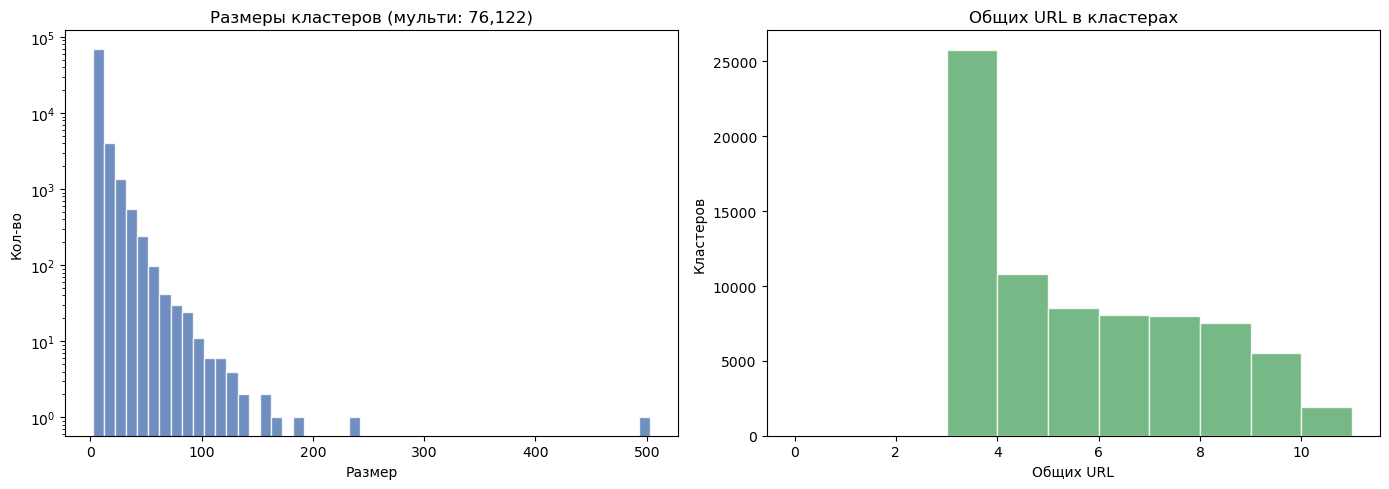

In [175]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

csizes = result_df.drop_duplicates("cluster_id")["cluster_size"]
ms = csizes[csizes > 1]
axes[0].hist(ms, bins=50, color="#4C72B0", edgecolor="white", alpha=0.8)
axes[0].set_title(f"Размеры кластеров (мульти: {len(ms):,})")
axes[0].set_xlabel("Размер"); axes[0].set_ylabel("Кол-во"); axes[0].set_yscale("log")

cu = result_df.drop_duplicates("cluster_id")
cu_m = cu[cu["cluster_size"]>1]["num_common_urls"]
axes[1].hist(cu_m, bins=range(0, int(cu_m.max())+2), color="#55A868", edgecolor="white", alpha=0.8)
axes[1].set_title("Общих URL в кластерах")
axes[1].set_xlabel("Общих URL"); axes[1].set_ylabel("Кластеров")
plt.tight_layout(); plt.show()

## Merge_Clusters

In [22]:
soft = pd.read_parquet('soft_clusters.parquet')
soft = soft[['cluster_id','cluster_size','keyword']]
soft = soft.rename(columns={'cluster_id':'soft_cluster_id','cluster_size':'soft_cluster_size'})
print(soft.shape[0])
soft.head()

540913


,soft_cluster_id,soft_cluster_size,keyword
0,1,902,07 какой регион
1,1,902,09 регион это какой город россии
2,1,902,1 регион какая область
3,1,902,10 регион какая
4,1,902,10 регион какая область


In [23]:
hard = pd.read_parquet('hard_clusters.parquet')
hard = hard[['cluster_id','cluster_size','keyword']]
print(hard.shape[0])
hard.head()

540913


,cluster_id,cluster_size,keyword
0,1,779,07 какой регион
1,1,779,09 регион это какой город россии
2,1,779,1 регион какая область
3,1,779,10 регион какая
4,1,779,10 регион какая область


In [24]:
result_df = pd.merge(soft,hard, on = 'keyword', how = 'left')

In [25]:
result_df = result_df[['soft_cluster_id','soft_cluster_size','cluster_id','cluster_size','keyword']]
print(result_df.shape[0])
result_df.head()

540913


,soft_cluster_id,soft_cluster_size,cluster_id,cluster_size,keyword
0,1,902,1,779,07 какой регион
1,1,902,1,779,09 регион это какой город россии
2,1,902,1,779,1 регион какая область
3,1,902,1,779,10 регион какая
4,1,902,1,779,10 регион какая область


## Merge_WS

In [26]:
ws = pd.read_parquet('keyword_with_freq.parquet')
ws = ws.rename(columns={'search_query': 'keyword'})
ws['sum'] = ws['sum'].astype(int)
ws = ws[['keyword','sum']]
print(ws.shape[0])
ws.head()

543426


,keyword,sum
0,куда поехать отдыхать в россии летом,438
1,куда поехать отдыхать в россии,269
2,куда поехать отдохнуть в россии,139
3,где отдохнуть в россии,392
4,где отдыхать в россии,25


In [27]:
result_df = pd.merge(result_df,ws, on = 'keyword', how = 'left')
print(result_df.shape[0])

540913


In [28]:
result_df.head()

,soft_cluster_id,soft_cluster_size,cluster_id,cluster_size,keyword,sum
0,1,902,1,779,07 какой регион,1124
1,1,902,1,779,09 регион это какой город россии,26
2,1,902,1,779,1 регион какая область,184
3,1,902,1,779,10 регион какая,232
4,1,902,1,779,10 регион какая область,4069


In [29]:
result_df = result_df.sort_values(by=['soft_cluster_size',\
                                      'soft_cluster_id',\
                                      'cluster_size', \
                                      'cluster_id',\
                                      'sum'
                                      ], ascending=[False, True, False, True, False])
result_df.head()

,soft_cluster_id,soft_cluster_size,cluster_id,cluster_size,keyword,sum
186,1,902,1,779,71 регион какая область,5033
10,1,902,1,779,11 регион какая область,4871
643,1,902,1,779,регион 39 какая область,4713
640,1,902,1,779,регион 27 какая область,4206
4,1,902,1,779,10 регион какая область,4069


## Постобработка

### TOP URL в рамках кластера

In [30]:
# Соединение фреймов по колонке "запрос"
merged_df = pd.merge(result_df, serp, on="keyword")
merged_df.head()

,soft_cluster_id,soft_cluster_size,cluster_id,cluster_size,keyword,sum,url
0,1,902,1,779,71 регион какая область,5033,https://cars.avtocod.ru/blog/otkuda-mashina-vs...
1,1,902,1,779,71 регион какая область,5033,https://m.avito.ru/auto-journal/kody-regionov-...
2,1,902,1,779,71 регион какая область,5033,https://ru.m.wikipedia.org/wiki/%d0%9a%d0%be%d...
3,1,902,1,779,71 регион какая область,5033,https://auto.ru/mag/article/avtomobilnye-kody-...
4,1,902,1,779,71 регион какая область,5033,https://finuslugi.ru/navigator/kak-ehto-rabota...


In [31]:
# Соединение фреймов по колонке "запрос"
merged_df = pd.merge(result_df, serp, on="keyword")

# Подсчет количества упоминаний каждого URL в рамках каждой категории
url_count_by_category = merged_df.groupby(['cluster_id', 'url']).size().reset_index(name='url_count')

# Сортировка URL по числу упоминаний по убыванию для каждой категории
sorted_urls_by_category = url_count_by_category.sort_values(
    by=['cluster_id', 'url_count'], ascending=[True, False])

# Создаем ранг для каждого URL внутри кластера
sorted_urls_by_category['rank'] = sorted_urls_by_category.groupby('cluster_id').cumcount() + 1

# Создаем аналогичный ранг для каждой строки в исходном датафрейме внутри кластера
#result_df = result_df.sort_values('cluster_id')
result_df['rank'] = result_df.groupby('cluster_id').cumcount() + 1

# Теперь выполняем merge по id_cluster И rank
result = pd.merge(
    result_df, 
    sorted_urls_by_category[['cluster_id', 'url', 'url_count', 'rank']], 
    on=['cluster_id', 'rank'], 
    how='left'
)

# Удаляем временную колонку rank
result = result.drop('rank', axis=1)



In [32]:
url_count_by_category = url_count_by_category.sort_values(by=['cluster_id', 'url_count'], \
                                                          ascending=[True, False])
url_count_by_category.head(20)

,cluster_id,url,url_count
8,1,https://auto.ru/mag/article/avtomobilnye-kody-...,779
79,1,https://ru.m.wikipedia.org/wiki/%d0%9a%d0%be%d...,779
145,1,https://www.sravni.ru/osago/info/avtomobilnye-...,779
116,1,https://www.banki.ru/wikibank/avtomobilnye_kod...,777
17,1,https://cars.avtocod.ru/blog/otkuda-mashina-vs...,697
127,1,https://www.consultant.ru/document/cons_doc_la...,674
74,1,https://quto.ru/journal/praktika/avtomobilnye-...,669
33,1,https://journal.sovcombank.ru/avtokrediti/vse-...,563
146,1,https://www.vbr.ru/avto/help/sovety-avtolyubit...,395
36,1,https://m.avito.ru/auto-journal/kody-regionov-...,334


In [275]:
# Проверяем результат
result = result.sort_values(by=['soft_cluster_size',\
                                      'soft_cluster_id',\
                                      'cluster_size', \
                                      'cluster_id',\
                                      ], ascending=[False, True, False, True])


In [33]:
result.head(30)

,soft_cluster_id,soft_cluster_size,cluster_id,cluster_size,keyword,sum,url,url_count
0,1,902,1,779,71 регион какая область,5033,https://auto.ru/mag/article/avtomobilnye-kody-...,779.0
1,1,902,1,779,11 регион какая область,4871,https://ru.m.wikipedia.org/wiki/%d0%9a%d0%be%d...,779.0
2,1,902,1,779,регион 39 какая область,4713,https://www.sravni.ru/osago/info/avtomobilnye-...,779.0
3,1,902,1,779,регион 27 какая область,4206,https://www.banki.ru/wikibank/avtomobilnye_kod...,777.0
4,1,902,1,779,10 регион какая область,4069,https://cars.avtocod.ru/blog/otkuda-mashina-vs...,697.0
5,1,902,1,779,регион 26 какая область,3117,https://www.consultant.ru/document/cons_doc_la...,674.0
6,1,902,1,779,регион 126 какая область,3000,https://quto.ru/journal/praktika/avtomobilnye-...,669.0
7,1,902,1,779,регион 42 какая область,2980,https://journal.sovcombank.ru/avtokrediti/vse-...,563.0
8,1,902,1,779,34 регион какая область,2867,https://www.vbr.ru/avto/help/sovety-avtolyubit...,395.0
9,1,902,1,779,регион 38 какая область,2734,https://m.avito.ru/auto-journal/kody-regionov-...,334.0


### Подсчет числа морд

In [34]:
#считаем главные страницы
def main_url(row):
    url = urlparse(row['url'])
    # Проверяем, заканчивается ли путь на слэш или является пустым
    if url.path == '/' or len(url.path) == 0:
        return 1
    else:
        return 0


In [35]:
serp['main_page'] = serp.progress_apply(main_url, axis=1)

  0%|          | 0/5393275 [00:00<?, ?it/s]

In [36]:
#main_page_by_keyword = serp.groupby(['Фраза', 'main_page']).sum().reset_index(name='Число морд')
main_page_by_keyword = serp.groupby(['keyword'])['main_page'].sum().reset_index(name='main_page')
result = pd.merge(result , main_page_by_keyword, on = 'keyword', how = 'left')

In [37]:
#df_result = df_result.sort_values(by=['id_merged_cluster', 'id_cluster','url_count'], ascending=[True, True,False])
result.head(20)

,soft_cluster_id,soft_cluster_size,cluster_id,cluster_size,keyword,sum,url,url_count,main_page
0,1,902,1,779,71 регион какая область,5033,https://auto.ru/mag/article/avtomobilnye-kody-...,779.0,0
1,1,902,1,779,11 регион какая область,4871,https://ru.m.wikipedia.org/wiki/%d0%9a%d0%be%d...,779.0,0
2,1,902,1,779,регион 39 какая область,4713,https://www.sravni.ru/osago/info/avtomobilnye-...,779.0,0
3,1,902,1,779,регион 27 какая область,4206,https://www.banki.ru/wikibank/avtomobilnye_kod...,777.0,0
4,1,902,1,779,10 регион какая область,4069,https://cars.avtocod.ru/blog/otkuda-mashina-vs...,697.0,0
5,1,902,1,779,регион 26 какая область,3117,https://www.consultant.ru/document/cons_doc_la...,674.0,0
6,1,902,1,779,регион 126 какая область,3000,https://quto.ru/journal/praktika/avtomobilnye-...,669.0,0
7,1,902,1,779,регион 42 какая область,2980,https://journal.sovcombank.ru/avtokrediti/vse-...,563.0,0
8,1,902,1,779,34 регион какая область,2867,https://www.vbr.ru/avto/help/sovety-avtolyubit...,395.0,0
9,1,902,1,779,регион 38 какая область,2734,https://m.avito.ru/auto-journal/kody-regionov-...,334.0,0


### TOP-URLs

In [38]:
url_counts = serp['url'].value_counts().reset_index()
url_counts.columns = ['url', 'встречается_раз']

# Подсчет количества уникальных запросов для каждого URL
unique_requests_per_url = serp.groupby('url')['keyword'].nunique().reset_index()
unique_requests_per_url.columns = ['url', 'количество_запросов']

# Объединение двух наборов данных
top_urls = pd.merge(url_counts, unique_requests_per_url, on='url')

top_urls.head(10)

,url,встречается_раз,количество_запросов
0,https://www.rzd.ru/,1869,1869
1,https://www.consultant.ru/law/ref/calendar/pro...,1498,1498
2,https://auto.ru/mag/article/avtomobilnye-kody-...,1042,1042
3,https://www.banki.ru/wikibank/avtomobilnye_kod...,1041,1041
4,https://secrets.tbank.ru/calendar/2026/,1002,1002
5,https://www.garant.ru/infografika/1828000/,966,966
6,https://www.consultant.ru/document/cons_doc_la...,914,914
7,https://ru.m.wikipedia.org/wiki/%d0%9a%d0%be%d...,913,913
8,https://travel.yandex.ru/journal/moscow/,900,900
9,https://cars.avtocod.ru/blog/otkuda-mashina-vs...,884,884


### TOP-Domains

In [39]:
#выделяем домены
def get_domain(row):
    url = urlparse(row['url'])
    domain = url.netloc
    # Убираем порт, если он есть
    domain = domain.split(':')[0]
    return domain

In [40]:
serp['domain'] = serp.progress_apply(get_domain, axis=1)

  0%|          | 0/5393275 [00:00<?, ?it/s]

In [41]:
domain_counts = serp['domain'].value_counts().reset_index()
domain_counts.columns = ['domain', 'встречается_раз']

# Подсчет количества уникальных запросов для каждого URL
unique_requests_per_domain = serp.groupby('domain')['keyword'].nunique().reset_index()
unique_requests_per_domain.columns = ['domain', 'Количество_запросов']

# Объединение двух наборов данных
top_domains = pd.merge(domain_counts, unique_requests_per_domain, on='domain')

top_domains.head(10)

,domain,встречается_раз,Количество_запросов
0,yandex.ru,257896,257353
1,dzen.ru,238437,238204
2,m.vk.com,155126,154273
3,travel.yandex.ru,141235,141153
4,ru.m.wikipedia.org,140235,140176
5,2gis.ru,108108,108018
6,www.tourister.ru,87687,87686
7,www.tripadvisor.ru,84520,84518
8,ru.ruwiki.ru,82692,82689
9,zoon.ru,63730,63729


### Сохранение результатов

In [42]:
#write results
#create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('result_file.xlsx', engine='xlsxwriter', engine_kwargs={'options': {'strings_to_urls': False}})


#semant
result.to_excel(writer, sheet_name='semant', index=False)

chunk_size = 1000000

#top domain by cluster

chunks = [url_count_by_category[i:i + chunk_size] for i in range(0, len(url_count_by_category), chunk_size)]

for i, chunk in enumerate(chunks, start=1):
    sheet_name = f'url_count_by_category_{i}'
    chunk.to_excel(writer, sheet_name=sheet_name, index=False)

#top_url---------
chunks = [top_urls[i:i + chunk_size] for i in range(0, len(top_urls), chunk_size)]

for i, chunk in enumerate(chunks, start=1):
    sheet_name = f'top_urls_{i}'
    chunk.to_excel(writer, sheet_name=sheet_name, index=False)
#top_domains---------
chunks = [top_domains[i:i + chunk_size] for i in range(0, len(top_domains), chunk_size)]

for i, chunk in enumerate(chunks, start=1):
    sheet_name = f'top_domains_{i}'
    chunk.to_excel(writer, sheet_name=sheet_name, index=False)
    
    
writer.close()

## ✅ 13. Валидация (опционально)

In [16]:
def validate_hard(kw2cluster, kw2urls, min_common, kw_enc, sample_size=50):
    """Валидация на случайной выборке кластеров (для скорости)."""
    import random
    cl2kws = defaultdict(list)
    for k, c in kw2cluster.items(): cl2kws[c].append(k)
    multi = {c: kws for c, kws in cl2kws.items() if len(kws) > 1}

    # Выборка
    sample_ids = random.sample(list(multi.keys()), min(sample_size, len(multi)))
    violations, checked = 0, 0

    for cl_id in tqdm(sample_ids, desc="Validating sample"):
        kw_ids = multi[cl_id]
        for i in range(len(kw_ids)):
            for j in range(i+1, len(kw_ids)):
                common = len(kw2urls.get(kw_ids[i],set()) & kw2urls.get(kw_ids[j],set()))
                checked += 1
                if common < min_common:
                    violations += 1
                    if violations <= 3:
                        print(f"  ❌ cluster {cl_id}: '{kw_enc.decode(kw_ids[i])}' ∩ "
                              f"'{kw_enc.decode(kw_ids[j])}' = {common}")

    if violations == 0:
        print(f"✅ PASSED: {checked:,} пар в {len(sample_ids)} кластерах, все ≥{min_common}")
    else:
        print(f"❌ FAILED: {violations:,}/{checked:,}")
    return violations == 0

# Раскомментируйте:
validate_hard(kw2cluster, kw2urls, MIN_COMMON_URLS, kw_enc, sample_size=100)

Validating sample:   0%|          | 0/100 [00:00<?, ?it/s]

✅ PASSED: 5,767 пар в 100 кластерах, все ≥3


True